In [282]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from gensim.models import KeyedVectors
import matplotlib
import matplotlib.pyplot as plt

from models import Wan
from utils import tokenize, word_to_index
from config import BATCH_SIZE, DEVICE, WORD_HIDDEN_SIZE

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = [20, 20]

In [284]:
df = pd.read_csv("data/yelp_test.csv").fillna("")
wv = KeyedVectors.load("embedding/yelp.wv")
model = Wan(
    embedding_matrix=wv.vectors,
    word_hidden_size=WORD_HIDDEN_SIZE,
    num_classes=len(df.label.unique()),
    batch_size=1,
)
model.load_state_dict(
    torch.load("models/yelp-wan-20200422-152139.pth", map_location=torch.device("cpu"))
)

<All keys matched successfully>

In [285]:
index = (
    df[(df["label"] == 4) & (df["text"].str.len() < 100)].sample(1).index.tolist()[0]
)
print(f"{index = }")
label, doc = df.loc[index]
print(f"{label = }")
print(doc)
tokens = tokenize(doc)
features = [word_to_index(doc, wv.vocab) for doc in tokens]
prediction = model(torch.LongTensor(features).unsqueeze(0)).argmax(1).item()
print(f"Predicted label: {prediction}")

index = 44991
label = 4
Definitely five stars for this place, Caps! The place is clean, great atmosphere, awesome staff, but best of all you can get a GREAT meal at 9pm. The boneless wings were awesome and there's a ton of sauces to choose from. Not to mention great beers on tap
Predicted label: 4


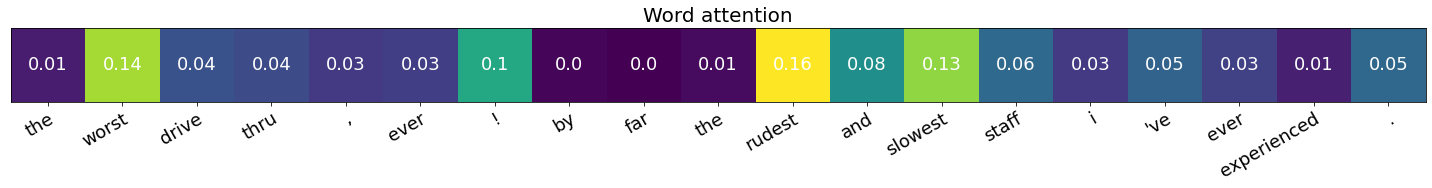

In [268]:
# Visualization of the attetion in the WAN

fig, ax = plt.subplots()
im = ax.imshow([model.word_attention.last_weights])
ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens, fontsize=18)
ax.set_title("Word attention", fontsize=20)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

# Add attention weight in each rectangle
for i in range(len(tokens)):
    ax.text(
        i,
        0,
        round(model.word_attention.last_weights[i], 2),
        fontsize=18,
        ha="center",
        va="center",
        color="w",
    )

# Remove y ticks
ax.yaxis.set_major_locator(plt.NullLocator())

fig.tight_layout()
#fig.savefig("visual_attn.pdf")